In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
image = cv.imread('soduku.png')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
normal_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

edges = cv.Canny(gray, 10, 100)

contours, hierarchy = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

biggest_contour = max(contours, key=cv.contourArea)

epsilon = 0.02 * cv.arcLength(biggest_contour, True)  
approx = cv.approxPolyDP(biggest_contour, epsilon, True)

if len(approx) == 4:
    rectangle_points = approx.reshape(4, 2)
    print("Rectangle Corner Points:", rectangle_points)
else:
    print("The contour is not a perfect rectangle.")


rectangle_points = sorted(rectangle_points, key=lambda x: (x[1], x[0]))
if rectangle_points[0][0] > rectangle_points[1][0]:  # Swap top-left and top-right if needed
    rectangle_points[0], rectangle_points[1] = rectangle_points[1], rectangle_points[0]
if rectangle_points[2][0] < rectangle_points[3][0]:  # Swap bottom-left and bottom-right if needed
    rectangle_points[2], rectangle_points[3] = rectangle_points[3], rectangle_points[2]

width = 252 
height = 252  
dst_points = np.array([
    [0, 0],        
    [width-1, 0],  
    [width-1, height-1], 
    [0, height-1] 
], dtype="float32")



M = cv.getPerspectiveTransform(np.float32(rectangle_points), dst_points)

warped = cv.warpPerspective(image, M, (width, height))

cv.imshow("Warped Perspective", warped)
cv.waitKey(0)
cv.destroyAllWindows()


Rectangle Corner Points: [[482  67]
 [ 70  83]
 [ 34 506]
 [510 511]]


In [4]:
gray_warped = cv.cvtColor(warped, cv.COLOR_BGR2GRAY)

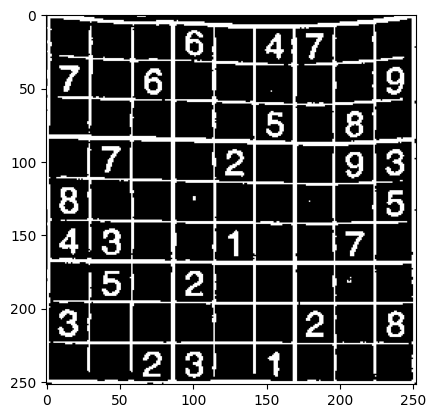

In [5]:
binary = cv.adaptiveThreshold(gray_warped, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV,15, 6)
plt.imshow(binary, cmap='gray')


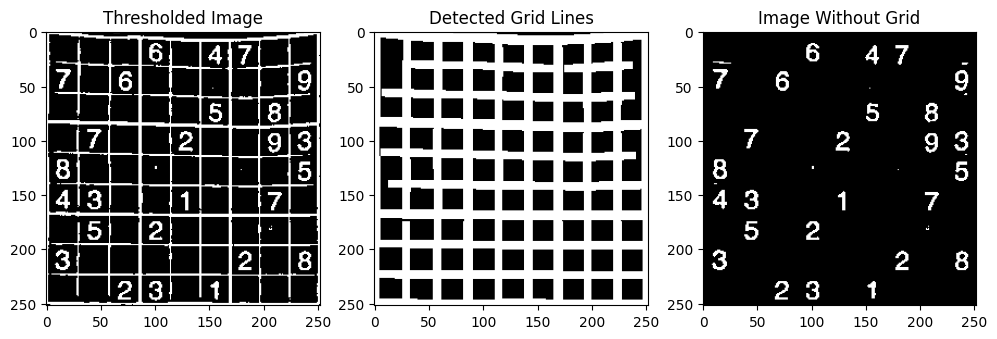

In [6]:
kernel_h = np.ones((1, 10), np.uint8) 
kernel_v = np.ones((10, 1), np.uint8)
horizontal_lines = cv.morphologyEx(binary, cv.MORPH_OPEN, kernel_h, iterations=2)
kernel = np.ones((3,3), np.uint8)
vertical_lines = cv.morphologyEx(binary, cv.MORPH_OPEN, kernel_v, iterations=2)
grid = cv.add(horizontal_lines, vertical_lines)
grid = cv.dilate(grid, kernel, iterations=3)
no_grid = cv.subtract(binary, grid)
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1), plt.imshow(binary, cmap='gray'), plt.title("Thresholded Image")
plt.subplot(1, 3, 2), plt.imshow(grid, cmap='gray'), plt.title("Detected Grid Lines")
plt.subplot(1, 3, 3), plt.imshow(no_grid, cmap='gray'), plt.title("Image Without Grid")
plt.show()

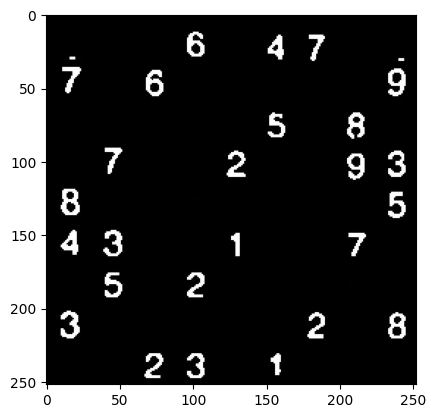

In [7]:
no_noise = cv.bilateralFilter(no_grid, 7, 90, 90)

no_noise = cv.medianBlur(no_noise, 3)
kernel = np.ones((2,2), np.uint8)  # Small kernel to remove noise

no_noise = cv.erode(no_noise, kernel, iterations=1)

no_noise = cv.dilate(no_noise, kernel, iterations=1)


plt.imshow(no_noise, cmap='gray')


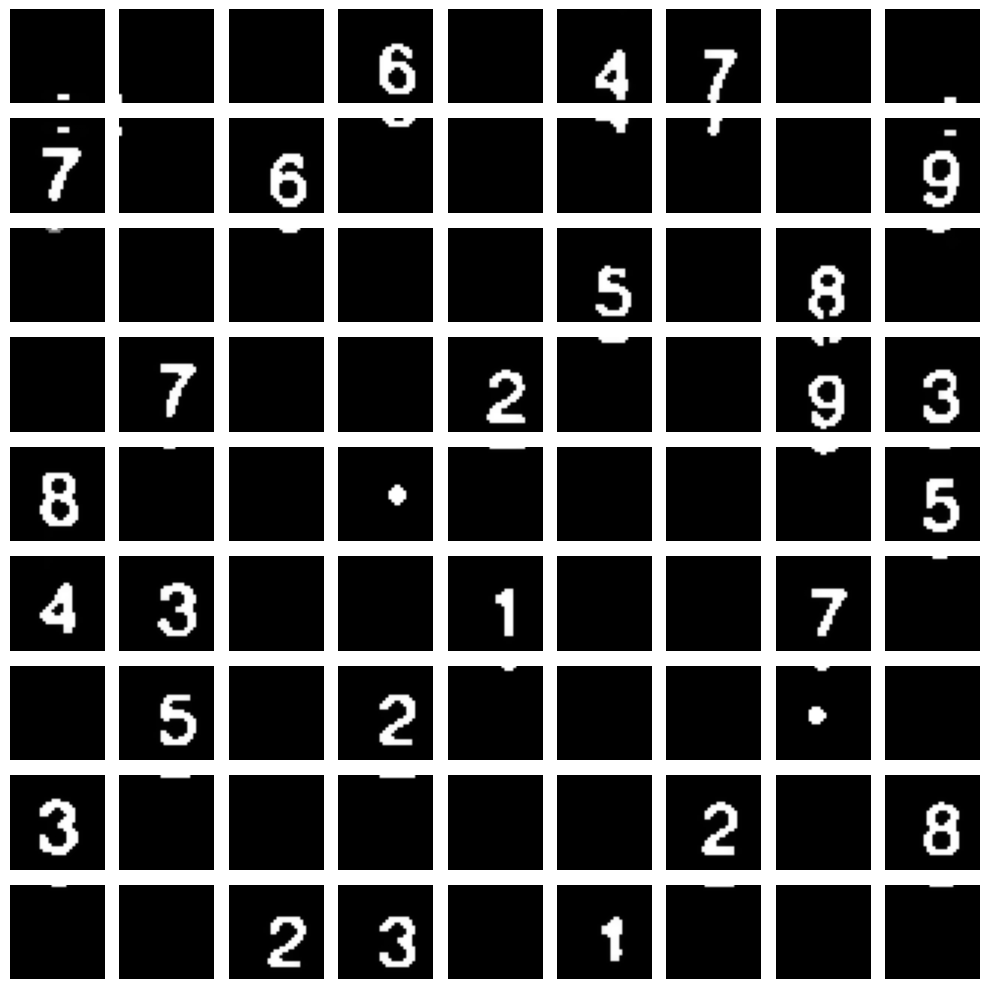

In [8]:
cell_size = 28  # Each cell is 28x28 pixels
grid_size = 9   # 9x9 Sudoku
new_size = 32

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

soduku_grid = []
soduku_idk = []

# Loop over each cell
for i in range(grid_size):
    for j in range(grid_size):
        # Extract the 28x28 cell from the image

        if i == 0 and j == 0:
            cell = no_noise[0:(i + 1) * new_size, 0:(j + 1) * new_size]
        
        elif i == 0 and j != 0 and j != 8:
            cell = no_noise[0:(i + 1) * new_size, (j * cell_size) - 2: ((j + 1) * cell_size) + 2]
        
        elif i == 0 and j == 8:
            cell = no_noise[0:(i + 1) * new_size, (j * cell_size) - 4: ((j + 1) * cell_size)]

        elif i == 8 and j == 0:
            cell = no_noise[(i * cell_size) - 4: ((i + 1) * cell_size), 0:(j + 1) * new_size]
        
        elif i == 8 and j == 8:
            cell = no_noise[(i * cell_size) - 4: ((i + 1) * cell_size), (j * cell_size) - 4: ((j + 1) * cell_size)]
        
        elif i == 8 and j != 0 and j != 8:
            cell = no_noise[(i * cell_size) - 4: ((i + 1) * cell_size), (j * cell_size) - 2: ((j + 1) * cell_size) + 2]
        
        elif i != 0 and i!= 8 and j == 0:
            cell = no_noise[(i * cell_size) - 2:((i + 1) * cell_size) + 2, 0:(j + 1) * new_size]
        
        elif i != 0 and i!= 8 and j == 8:
            cell = no_noise[(i * cell_size) - 2:((i + 1) * cell_size) + 2, (j * cell_size) - 4: ((j + 1) * cell_size)]
        
        elif i != 0 and i!= 8 and j != 0 and j != 8:
            cell = no_noise[(i * cell_size) -2 :((i + 1) * cell_size) + 2, (j * cell_size) -2:((j + 1) * cell_size) + 2]
        
        else: 
            print(f"i = {i}, j = {j}")

        
        # Display in the subplot

        soduku_idk.append(cell) 
        axes[i, j].imshow(cell, cmap='gray')
        axes[i, j].axis("off")  # Hide axes for clarity
    
    soduku_grid.append(soduku_idk)
    soduku_idk = []

plt.tight_layout()
plt.show()

In [9]:
soduku_filled = [[True] * 9 for _ in range(9)]
print(soduku_filled)
    
for i in range(grid_size):
    for j in range(grid_size):
        if np.mean(soduku_grid[i][j]) < 10:  # Adjust threshold
            soduku_grid[i][j] = np.zeros_like(soduku_grid[i][j])
            soduku_filled[i][j] = False

[[True, True, True, True, True, True, True, True, True], [True, True, True, True, True, True, True, True, True], [True, True, True, True, True, True, True, True, True], [True, True, True, True, True, True, True, True, True], [True, True, True, True, True, True, True, True, True], [True, True, True, True, True, True, True, True, True], [True, True, True, True, True, True, True, True, True], [True, True, True, True, True, True, True, True, True], [True, True, True, True, True, True, True, True, True]]


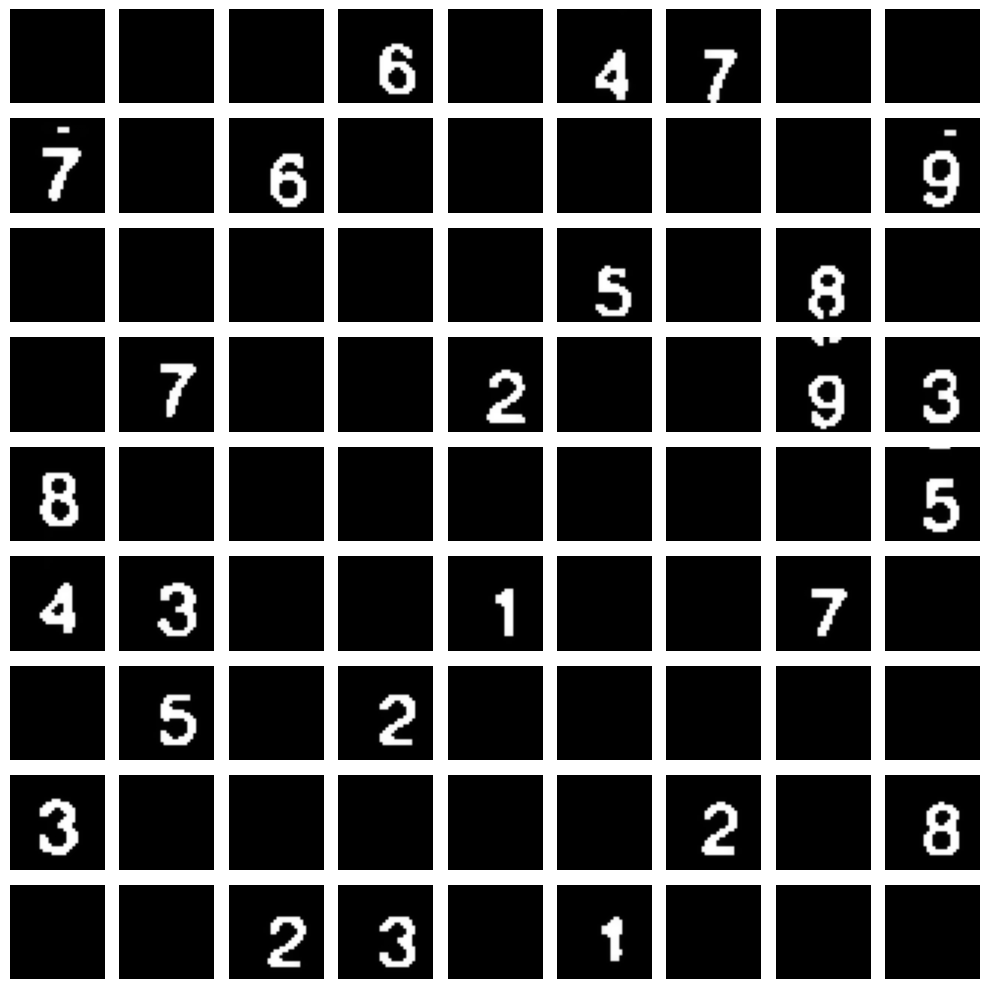

In [10]:
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for i in range(grid_size):
    for j in range(grid_size):
        axes[i, j].imshow(soduku_grid[i][j], cmap='gray')
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

In [11]:
def center_image(image):
    # Find the coordinates of non-zero pixels
    non_zero_indices = np.nonzero(image)
    
    # Calculate the centroid (mean of non-zero pixel coordinates)
    centroid_x = np.mean(non_zero_indices[0])
    centroid_y = np.mean(non_zero_indices[1])
    
    # Calculate the center of the image (in this case, 16, 16 for a 32x32 image)
    center_x = image.shape[0] // 2
    center_y = image.shape[1] // 2
    
    # Calculate the shift required to center the image
    shift_x = int(center_x - centroid_x)
    shift_y = int(center_y - centroid_y)
    
    # Create a new empty image (32x32) initialized with zeros
    centered_image = np.zeros_like(image)
    
    # Shift the non-zero pixels into the new image
    for i in range(len(non_zero_indices[0])):
        x, y = non_zero_indices[0][i], non_zero_indices[1][i]
        new_x = x + shift_x
        new_y = y + shift_y
        if 0 <= new_x < image.shape[0] and 0 <= new_y < image.shape[1]:
            centered_image[new_x, new_y] = image[x, y]
    
    return centered_image

In [12]:
def denoising_image(cell):
    _, thresh = cv.threshold(cell, 128, 255, cv.THRESH_BINARY)

# Find contours
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Find the largest contour based on area
    largest_contour = max(contours, key=cv.contourArea)

    # Create a blank mask
    mask = np.zeros_like(cell)

    # Draw the largest contour on the mask
    cv.drawContours(mask, [largest_contour], -1, 255, thickness=cv.FILLED)

    # Apply the mask to remove noise
    denoised = cv.bitwise_and(cell, mask)
    
    return denoised
    

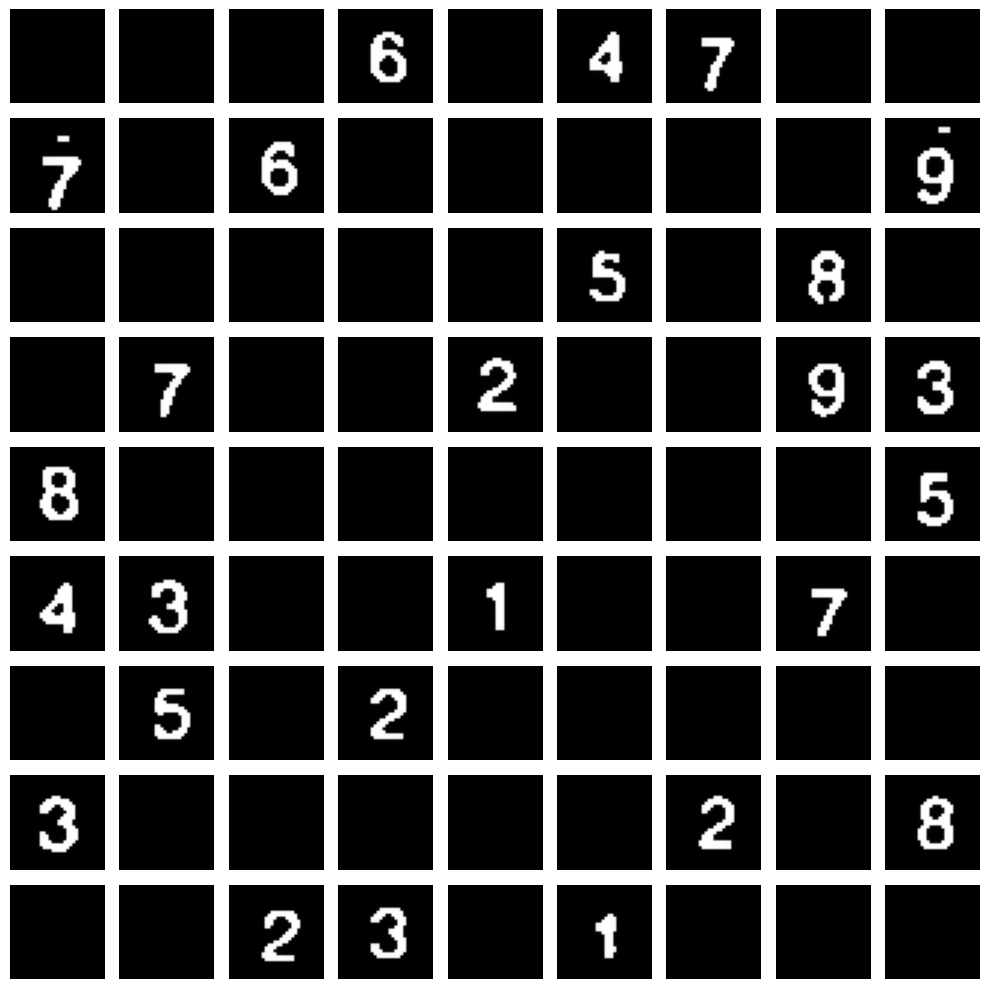

In [13]:
for i in range(grid_size):
    for j in range(grid_size):

        if soduku_filled[i][j] == False:
            continue
        for k in range(10):
            soduku_grid[i][j] = center_image(soduku_grid[i][j])

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for i in range(grid_size):
    for j in range(grid_size):
        axes[i, j].imshow(soduku_grid[i][j], cmap='gray')
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

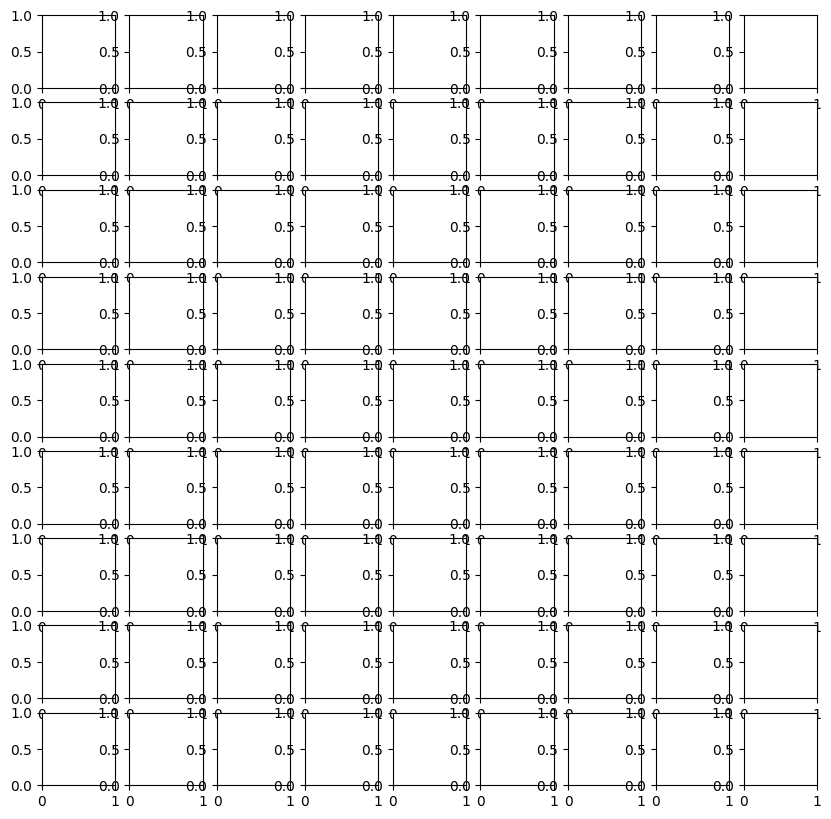

In [14]:
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i in range(grid_size):
    for j in range(grid_size):

        if soduku_filled[i][j] == False:
            continue
        
        soduku_grid[i][j] = denoising_image(soduku_grid[i][j])


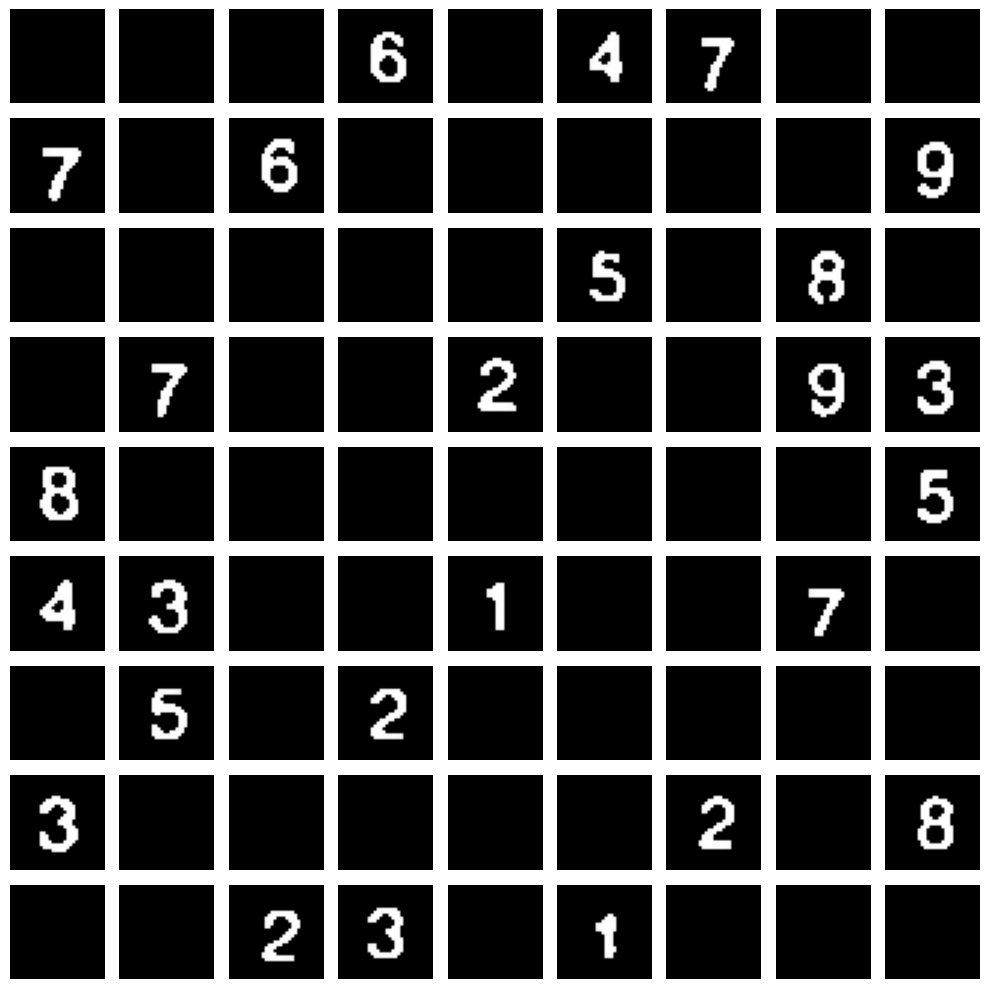

In [15]:
for i in range(grid_size):
    for j in range(grid_size):

        if soduku_filled[i][j] == False:
            continue
        for k in range(10):
            soduku_grid[i][j] = center_image(soduku_grid[i][j])

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for i in range(grid_size):
    for j in range(grid_size):
        axes[i, j].imshow(soduku_grid[i][j], cmap='gray')
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

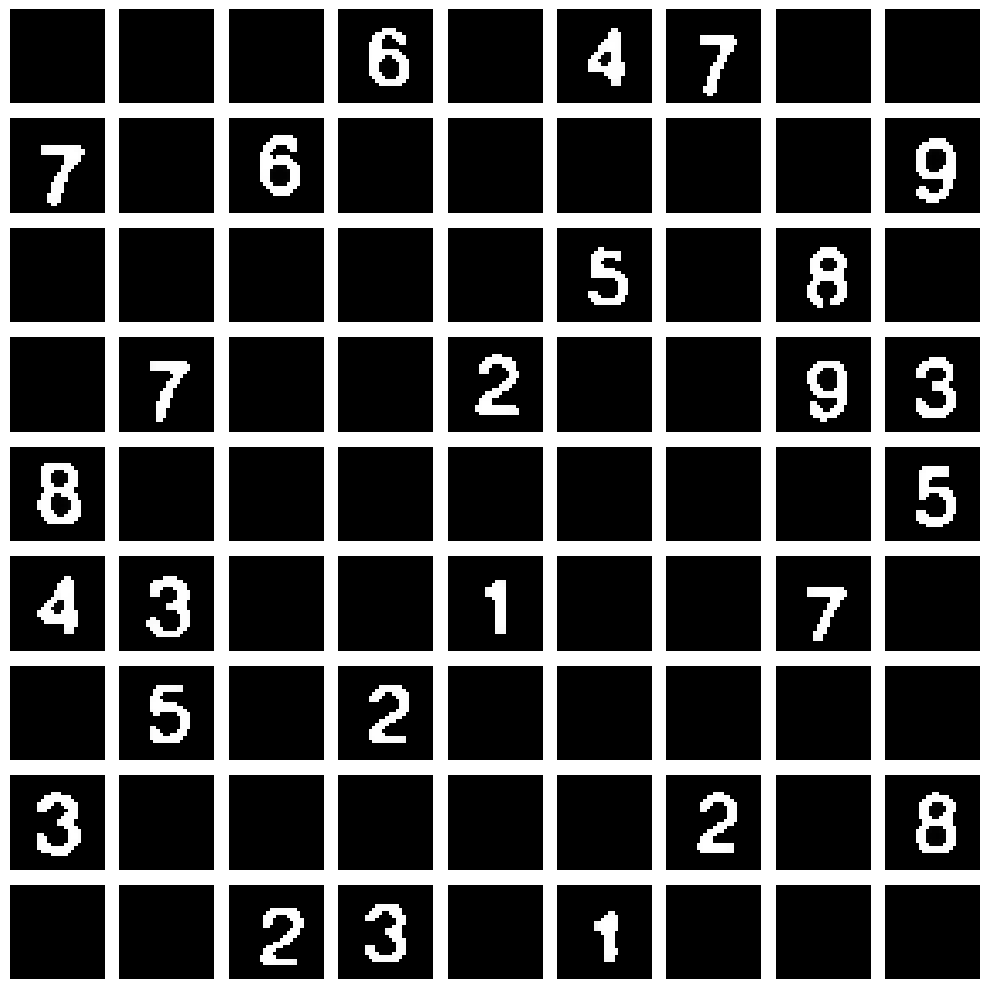

In [16]:
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i in range(grid_size):
    for j in range(grid_size):
        soduku_grid[i][j] = soduku_grid[i][j][2:30, 2:30]
        axes[i, j].imshow(soduku_grid[i][j], cmap='gray')
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

In [17]:
import joblib
from sklearn.neighbors import KNeighborsClassifier

In [18]:
model = joblib.load('knnmodel.pkl')


In [19]:
print(model.predict(soduku_grid[3][7].reshape(-1, 784)))

[8.]


In [20]:
kernel = np.ones((3,3), np.uint8)
vertical_lines = cv.morphologyEx(binary, cv.MORPH_OPEN, kernel_v, iterations=2)
grid = cv.add(horizontal_lines, vertical_lines)
grid = cv.erode(grid, kernel, iterations=3)

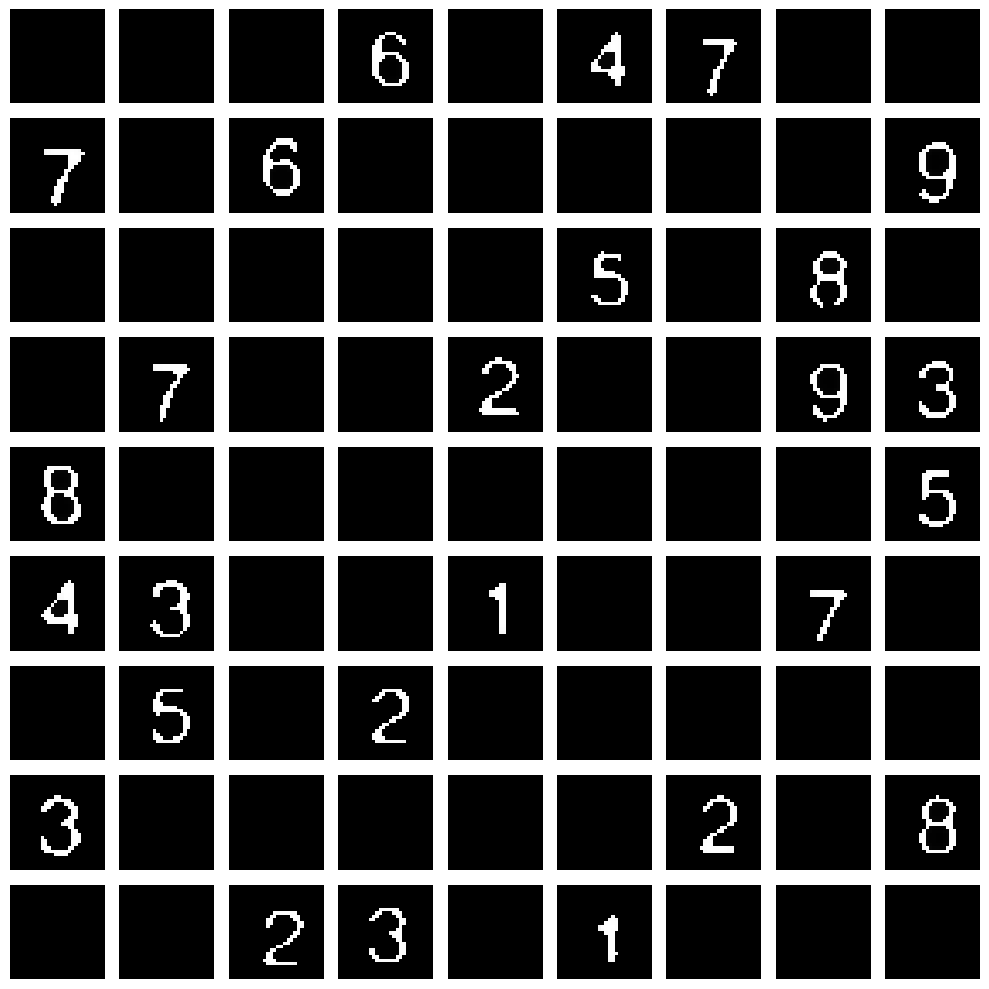

In [21]:
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
kernel = np.ones((2,2), np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        soduku_grid[i][j] = cv.erode(soduku_grid[i][j], kernel, iterations=1)
        axes[i, j].imshow(soduku_grid[i][j], cmap='gray')
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

In [22]:
print(model.predict(soduku_grid[2][7].reshape(-1, 784)))

[3.]


In [23]:
for i in range(grid_size):
    for j in range(grid_size):

        if soduku_filled[i][j] == False:
            continue
        for k in range(10):
            soduku_grid[i][j] = center_image(soduku_grid[i][j])

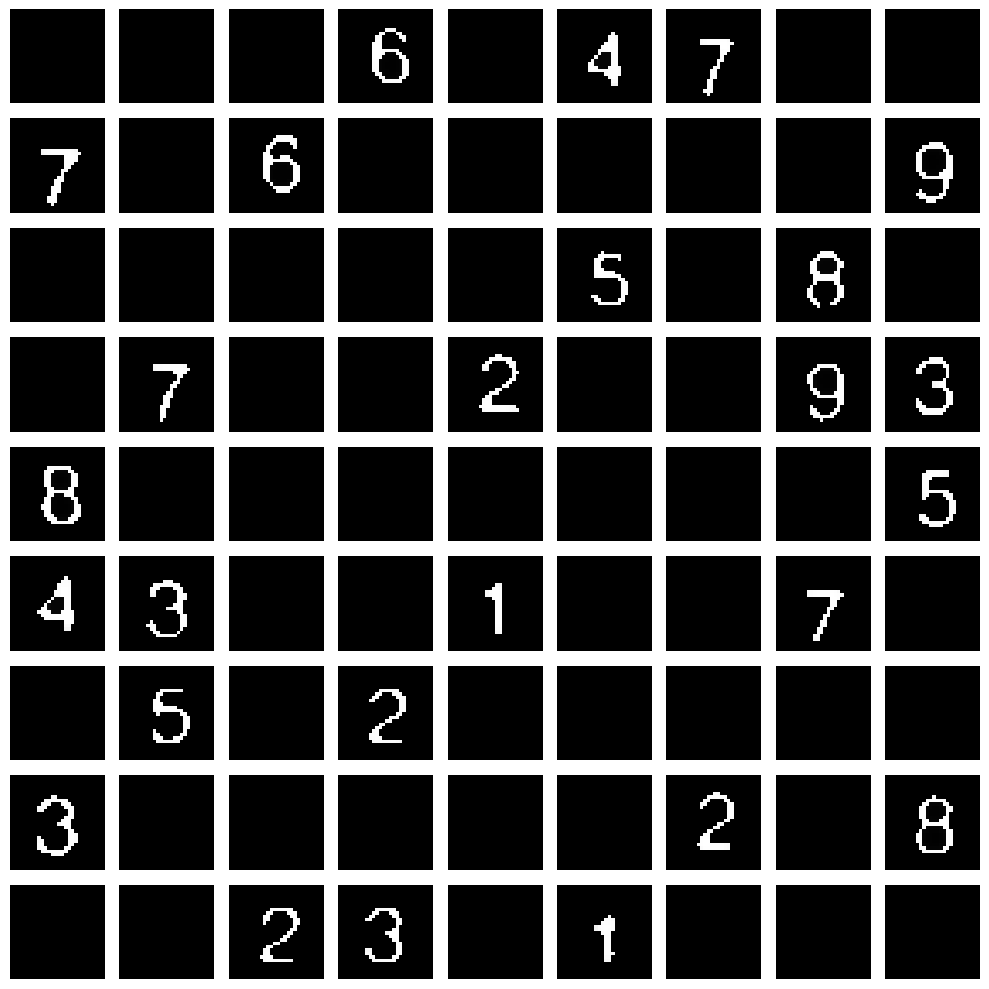

In [24]:
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for i in range(grid_size):
    for j in range(grid_size):
        axes[i, j].imshow(soduku_grid[i][j], cmap='gray')
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

In [25]:
print(model.predict(soduku_grid[1][0].reshape(-1, 784)))

[7.]


In [26]:
from tensorflow.keras.models import load_model
input_image = soduku_grid[3][7]  # Assuming this is a single 28x28 image

# Reshape to (1, 28, 28, 1) for a single image
input_image = input_image.reshape(1, 28, 28, 1)

# Normalize the image (assuming it's in pixel range [0, 255])
input_image = input_image.astype("float32") / 255.0
# Load the model
model = load_model('cnn_model.h5')

# Now you can use the model to make predictions
predictions = model.predict(input_image)
print(predictions)

2025-03-07 11:42:41.883781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741335161.911039   14543 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741335161.918595   14543 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 11:42:41.939998: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1741335163.716656   14543 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 34

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
[[1.3177736e-06 1.3703571e-05 3.9144074e-06 3.7288889e-02 1.0381084e-04
  3.6586214e-02 9.1911625e-06 9.0659385e-05 2.2433601e-02 9.0346867e-01]]


I0000 00:00:1741335165.417131   14631 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [27]:
predicted_class = np.argmax(predictions, axis=1)
print(predicted_class)

[9]


In [28]:
main_soduku = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]
    ]

In [29]:
model = load_model('cnn_model.h5')
for i in range(grid_size):
    for j in range(grid_size):

        if soduku_filled[i][j] == False:

            continue

        input_image = soduku_grid[i][j]  # Assuming this is a single 28x28 image

        input_image = input_image.reshape(1, 28, 28, 1)

        input_image = input_image.astype("float32") / 255.0

        predictions = model.predict(input_image)
        predicted_class = np.argmax(predictions, axis=1)

        main_soduku[i][j] = int(predicted_class[0]) if isinstance(predicted_class[0], np.ndarray) else predicted_class[0]

        print(f"for i = {i + 1} and j = {j+1} we have: {predicted_class}")

    
        

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
for i = 1 and j = 4 we have: [6]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
for i = 1 and j = 6 we have: [4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
for i = 1 and j = 7 we have: [7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
for i = 2 and j = 1 we have: [7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
for i = 2 and j = 3 we have: [5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
for i = 2 and j = 9 we have: [9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
for i = 3 and j = 6 we have: [5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
for i = 3 and j = 8 we have: [8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
for i = 4 and j = 2 we have: [7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
for i = 4 and j = 5 we have: [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
for i = 4 and j = 8 we have: [9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
for i = 4 and j = 9 we have: [3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
for i = 5 and j = 1 we have: [8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
for i = 5 and j = 9 we have: [5]
1/1 ━

In [30]:
from colorama import Fore, Back, Style


def check(main_sudoku, m, x, y):
    list_tekrari = []
    
    # Check the row
    for j in range(9):
        if main_sudoku[x][j] == m and j != y and m != 0:
            list_tekrari.append([x, j])
    
    # Check the column
    for i in range(9):
        if main_sudoku[i][y] == m and i != x and  m != 0  :
            list_tekrari.append([i, y])
    
    # Check the 3x3 block
    start_row = (x // 3) * 3
    start_col = (y // 3) * 3
    for i in range(start_row, start_row + 3):
        for j in range(start_col, start_col + 3):
            if main_sudoku[i][j] == m and (i != x or j != y) and m != 0:
                list_tekrari.append([i, j])
    
    # Add the current position
    list_tekrari.append([x, y])
    
    return list_tekrari

def print_main_soduku(main_soduku : list, initials_list : list) :
    for i in range(9):
        for j in range(9):
            if j % 3 != 2:
                list_tekrari = check(main_soduku, main_soduku[i][j], i, j)
                if len(list_tekrari) >= 2 :
                    print(f"{Fore.RED}{main_soduku[i][j]}{Style.RESET_ALL}|",end='')
                elif [i, j] in initials_list :
                    print(f"{main_soduku[i][j]}|", end ='')
                elif main_soduku[i][j] != 0:
                    print(f"{Fore.YELLOW}{main_soduku[i][j]}{Style.RESET_ALL}|",end = '')
                else :
                    print(f"{main_soduku[i][j]}|", end = '')
            elif j % 3 == 2:
                list_tekrari = check(main_soduku, main_soduku[i][j], i, j)
                if len(list_tekrari) >= 2 :
                    print(f"{Fore.RED}{main_soduku[i][j]}{Style.RESET_ALL} |*| ",end='')
                elif [i, j] in initials_list :
                    print(f"{main_soduku[i][j]} |*| ", end ='')
                elif main_soduku[i][j] != 0:
                    print(f"{Fore.YELLOW}{main_soduku[i][j]}{Style.RESET_ALL} |*| ",end = '')
                else :
                    print(f"{main_soduku[i][j]} |*| ", end = '')
            if j == 8 :
                print()
        if i % 3 == 2 :
            print('=' * 29)

In [ ]:
main_soduku[1][2] = 6
print_main_soduku(main_soduku, main_soduku)


0|0|0 |*| 6|0|4 |*| 7|0|0 |*| 
7|0|5 |*| 0|0|0 |*| 0|0|9 |*| 
0|0|0 |*| 0|0|5 |*| 0|8|0 |*| 
0|7|0 |*| 0|2|0 |*| 0|9|3 |*| 
8|0|0 |*| 0|0|0 |*| 0|0|5 |*| 
4|3|0 |*| 0|1|0 |*| 0|7|0 |*| 
0|5|0 |*| 2|0|0 |*| 0|0|0 |*| 
3|0|0 |*| 0|0|0 |*| 2|0|8 |*| 
0|0|2 |*| 3|0|1 |*| 0|0|0 |*| 


In [ ]:
def win_check(main_soduko : list) -> bool :
    for i in range(9):
        for j in range(9):
            if main_soduko[i][j] == 0:
                return False
    for i in range(9):
        for j in range(9):
            if(len(check(main_soduko, main_soduko[i][j], i, j)) > 1 ):
                return False

def initails_list_maker(main_soduku: list) -> list:
    initials_list = []
    for i in range(9):
        for j in range(9):
            if main_soduku[i][j] != 0 :
                initials_list.append([i, j])
    return initials_list


def clear_board(main_sudoku: list, x : int, y : int):
    main_sudoku[x][y] = 0
def find_empty(main_soduku : list):
    for i in range(9):
        for j in range(9):
            if main_soduku[i][j] == 0:
                return i, j
    return -1, -1

def soduku_csp(main_soduku : list, back_track_csp : list, bool_check : bool, initials_list : list):
    if bool_check :
        x, y = find_empty(main_soduku)
        if x == -1:
            print_main_soduku(main_soduku, initials_list)
            exit()
        flag = 0
        for i in range(1, 10):
            list_tekrari = check(main_soduku, i, x, y)
            if len(list_tekrari) < 2 :
                back_track_csp.append([x, y, i])
                main_soduku[x][y] = i
                flag = 1
                return main_soduku, back_track_csp, True, initials_list
        if flag == 0 :
            return main_soduku, back_track_csp, False, initials_list
    else :
        if back_track_csp == []:
            print('invalid')
            exit()
        cell = back_track_csp.pop()
        x = cell[0]
        y = cell[1]
        clear_board(main_soduku, x, y)
        flag = 0
        for i in range(cell[2] + 1 , 10):
            list_tekrari = check(main_soduku, i, x, y)
            if len(list_tekrari) < 2 :
                back_track_csp.append([x, y, i])
                main_soduku[x][y] = i
                flag = 1
                return main_soduku, back_track_csp, True, initials_list
        if flag == 0:
            return main_soduku, back_track_csp, False, initials_list

In [ ]:
back_track_csp = []
bool_check = True
initials_list = initails_list_maker(main_soduku)

step = 0
while not win_check(main_soduku):
    main_soduku, back_track_csp, bool_check, initials_list = soduku_csp(main_soduku, back_track_csp, bool_check , initials_list)

    step += 1

    if step == 100000:
        print("no way found")

5|8|3 |*| 6|9|4 |*| 7|2|1 |*| 
7|1|6 |*| 8|3|2 |*| 5|4|9 |*| 
2|9|4 |*| 1|7|5 |*| 3|8|6 |*| 
6|7|1 |*| 5|2|8 |*| 4|9|3 |*| 
8|2|9 |*| 7|4|3 |*| 1|6|5 |*| 
4|3|5 |*| 9|1|6 |*| 8|7|2 |*| 
1|5|8 |*| 2|6|7 |*| 9|3|4 |*| 
3|6|7 |*| 4|5|9 |*| 2|1|8 |*| 
9|4|2 |*| 3|8|1 |*| 6|5|7 |*| 
invalid


IndexError: pop from empty list

: 

In [34]:
def is_valid(board, row, col, num):
    for i in range(9):
        if board[row][i] == num or board[i][col] == num:
            return False

    start_row, start_col = (row // 3) * 3, (col // 3) * 3
    for i in range(3):
        for j in range(3):
            if board[start_row + i][start_col + j] == num:
                return False

    return True


def solve_sudoku(board):
    for row in range(9):
        for col in range(9):
            if board[row][col] == 0:  
                for num in range(1, 10):
                    if is_valid(board, row, col, num):
                        board[row][col] = num
                        if solve_sudoku(board):
                            return True 
                        board[row][col] = 0 

                return False  
    return True  

def print_board(board):
    for i in range(9):
        if i % 3 == 0 and i != 0:
            print("- - - + - - - + - - -")
        for j in range(9):
            if j % 3 == 0 and j != 0:
                print("|", end=" ")
            print(board[i][j] if board[i][j] != 0 else ".", end=" ")
        print()

        

In [35]:
if solve_sudoku(main_soduku):
    print("\nSolved Sudoku:")
    print_board(main_soduku)
else:
    print("No solution exists.")


Solved Sudoku:
5 8 3 | 6 9 4 | 7 2 1 
7 1 6 | 8 3 2 | 5 4 9 
2 9 4 | 1 7 5 | 3 8 6 
- - - + - - - + - - -
6 7 1 | 5 2 8 | 4 9 3 
8 2 9 | 7 4 3 | 1 6 5 
4 3 5 | 9 1 6 | 8 7 2 
- - - + - - - + - - -
1 5 8 | 2 6 7 | 9 3 4 
3 6 7 | 4 5 9 | 2 1 8 
9 4 2 | 3 8 1 | 6 5 7 
